In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge
from robust_PDE_FIND import RobustPCA
from best_subset import *
from UBIC import *
from solvel0 import solvel0
from findiff import FinDiff

from sklearn.decomposition import PCA, TruncatedSVD
from skimage.restoration import denoise_wavelet, estimate_sigma

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([-1, -1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

Sklearn's version: 1.2.2


#### Load data

In [2]:
data = sio.loadmat('../Datasets/kuramoto_sivishinky.mat')
u = data['uu']
x = data['x'][:,0]
t = data['tt'][0,:]
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

#### Visualization

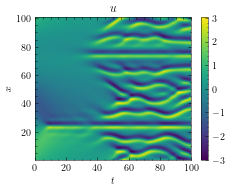

In [3]:
with plt.style.context(['science']):
    ufig, uax = plt.subplots()
    contour = uax.pcolormesh(t, x, u, shading='gouraud')
    uax.set_xlabel("$t$")
    uax.set_ylabel("$x$")
    uax.set_title("$u$")
    cbar = ufig.colorbar(contour)
    ufig.savefig("../Figures/ks.png", dpi=300)
    plt.show()

#### Add noise

In [4]:
np.random.seed(0)
noise_lv = 30
un = u + 0.01*noise_lv*u.std()*np.random.randn(u.shape[0],u.shape[1])

In [5]:
print(np.linalg.norm(u-un, ord='fro'), np.linalg.norm(u-un, ord=np.inf))

162.0628099100219 73.75161772179317


#### Use the precomputed denoised variable given by the K-SVD

In [6]:
is_u_denoised = True
if is_u_denoised:
    print("Loading denoised data...")
    denoised_un = np.load("./denoised_files/KS_noise30_reduced_dctV2ksvdreg_25x25.npy")
    # un = denoised_un
    
    ### PCA ###
#     target_percentage = 95
#     summ = 0.0
#     n_components = 0
#     sigma = PCA(n_components=un.shape[-1]).fit(un).explained_variance_ratio_
#     for s in sigma:
#         summ += s
#         n_components += 1
#         if summ > target_percentage/100:
#             break
#     print(n_components, summ)
#     assert n_components < len(sigma)
#     pca = PCA(n_components=n_components).fit(un)
#     pca_un = pca.inverse_transform(pca.transform(un))
#     un = pca_un

    ### Revised PCA ###
#     target_percentage = 99.5
#     Sigma = PCA(n_components=un.shape[-1]).fit(un).explained_variance_ratio_
#     # sigma = Sigma/Sigma.sum() # if .explained_variance_ is used above
#     summ = np.cumsum(100*Sigma)
#     n_components = np.argmax(summ>target_percentage)+1
#     assert n_components < len(Sigma)
#     print(n_components, summ[n_components-1])
#     pca = PCA(n_components=n_components).fit(un)
#     pca_un = pca.inverse_transform(pca.transform(un))
#     un = pca_un
    
    ### SVD ###
#     target_percentage = 99.99 # 90, 95, 99.99
#     U, Sigma, V = np.linalg.svd(un, full_matrices=False); V = V.T
#     sigma = (Sigma.copy())**2
#     sigma = sigma/sigma.sum()
#     summ = np.cumsum(100*sigma)
#     n_components = np.argmax(summ>target_percentage)+1
#     assert n_components < len(Sigma)
#     svd_un = U[:, 0:n_components].dot(np.diag(Sigma[0:n_components]).dot(V[:,0:n_components].T))
#     print(n_components, summ[n_components-1])
#     un = svd_un
    
    ### Wavelet denoising ###
#     wavelet_un = denoise_wavelet(un, channel_axis=None, convert2ycbcr=False, 
#                                  sigma=estimate_sigma(un, channel_axis=None, average_sigmas=True), 
#                                  method='BayesShrink', mode='soft', rescale_sigma=True)
#     un = wavelet_un

    ### Robust PCA ###
#     rpca_lam = 0.1
#     un, _ = RobustPCA(un, rpca_lam)

    ### FFT ###
    def remove_f(uu, percent):
        if percent <= 0: return uu
        # PSD = (uu*np.conj(uu)) # also valid
        PSD = (uu*np.conj(uu))/np.prod(uu[0, :].shape)
        PSD = PSD.real
        mask = (PSD>=np.percentile(PSD, percent)).astype(np.float32)
        return uu*mask
    remove_percent = 50
    un = ifft(remove_f(fft(un), remove_percent)).real
    
    l_F, l_inf = np.linalg.norm(u-un, ord='fro'), np.linalg.norm(u-un, ord=np.inf)
    print(l_F, l_inf)

Loading denoised data...
148.51913887859433 68.97187431581114


In [7]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

STLSQ model: 
(x0)' = -0.994 x0_11 + -0.996 x0_1111 + -0.992 x0x0_1


#### Applying best-subset regression on the weak formulation

In [8]:
class FiniteDifferentiator(ps.BaseDifferentiation):
    def __init__(self, acc=2, d=1, axis=1, is_uniform=True, periodic=False):
        super(FiniteDifferentiator, self).__init__()        
        self.acc = acc
        self.d = d
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        
    def _differentiate(self, x, t):
        if self.is_uniform:
            if isinstance(t, float): 
                dt = t
            else: 
                dt = t[1]-t[0]
            self.diff = FinDiff(self.axis, dt, self.d, acc=self.acc)
        else:
            raise NotImplementedError("is_uniform=False")
            self.diff = FinDiff(self.axis, self.d, acc=self.acc)
        return self.diff(x)

differentiation_method, differentiation_kwargs = FiniteDifferentiator, {'acc':4}
diff_order = 4
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=4, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}

In [9]:
optimizer_name = "miosr" # "l0bnb", "miosr"
assert (optimizer_name == "l0bnb") or (optimizer_name == "miosr")
if optimizer_name == "l0bnb":
    optimizer = L0BNB(max_nonzeros=4, lam=5e-2, is_normal=True, normalize_columns=False, threshold=1e-4)
elif optimizer_name == "miosr":
    optimizer = ps.MIOSR(target_sparsity=3, alpha=5e-2, normalize_columns=False, regression_timeout=100)
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 differentiation_method=differentiation_method(**differentiation_kwargs), 
                 cache=True,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
model.get_feature_names()
X_pre, y_pre = np.squeeze(model.feature_library.cached_xp_full), model.cached_x_dot

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


In [10]:
print("From brute-force solver")
best_subsets = [tuple(np.where(abs(brute_force(X_pre, y_pre, support_size=i).flatten())>0)[0]) 
                for i in range(1, X_pre.shape[1]+1)]
best_subsets

From brute-force solver


[(6,),
 (3, 6),
 (3, 5, 6),
 (3, 5, 6, 10),
 (3, 4, 5, 6, 10),
 (2, 3, 5, 6, 10, 11),
 (2, 3, 5, 6, 7, 10, 11),
 (2, 3, 4, 5, 6, 7, 10, 11),
 (2, 3, 4, 5, 6, 7, 10, 11, 13),
 (0, 2, 3, 4, 5, 6, 7, 10, 11, 13),
 (0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13),
 (0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)]

#### Model selection by the UBIC (Algorithm 1)

In [11]:
tau = 3; per = 75
scale = np.log(len(y_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets])
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])        
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(max(lower_bounds/(b_uns*scale)), 1e-6))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
# 4.440892098500626e-16
last_lam, last_ubic, last_bc

threshold: 0.829673254200554
2 <---> 2 inf
2 <---> 3 0.0006874693471047986


(2.0983474211932105,
 array([ 44568.85116123,  35063.6003997 , -11780.79547566, -11760.50242014,
        -11620.15285145, -11365.64167943, -11103.74318562, -10763.85228424,
        -10692.44919973, -10378.2421003 , -10367.54369719, -10308.0601643 ,
        -10229.74573931, -10124.85982987]),
 2)

In [12]:
tau = 3; per = 75
scale = np.log(len(y_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets])
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])        
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-com
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(max(lower_bounds/(b_uns*scale)), 1e-6))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1
# 4.440892098500626e-16
last_lam, last_ubic, last_bc

threshold: 0.829673254200554
2 <---> 2 inf
2 <---> 3 0.0006874693471047986


(2.0983474211932105,
 array([ 44568.85116123,  35063.6003997 , -11780.79547566, -11760.50242014,
        -11620.15285145, -11365.64167943, -11103.74318562, -10763.85228424,
        -10692.44919973, -10378.2421003 , -10367.54369719, -10308.0601643 ,
        -10229.74573931, -10124.85982987]),
 2)

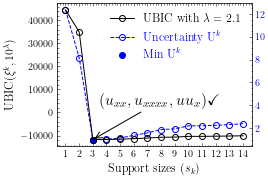

In [13]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    ax.annotate('$(u_{xx}, u_{xxxx}, uu_{x})\checkmark$', fontsize=16, 
                 xy=(complexity_axis[best_bc], last_ubic[best_bc]), 
                 xytext=(complexity_axis[best_bc]+0.5, last_ubic[best_bc]+15000), 
                 arrowprops={'arrowstyle': '->'})
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {abs(round(last_lam,2))}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper right', fontsize=12)
    
    plt.show()

#### Percent coefficient error

In [14]:
# print(n_components, summ[n_components-1])
print(l_F, l_inf)
# (0.38132791930786114, 0.07431246710249238)
evaluate_coefficients(np.linalg.lstsq(X_pre[:, best_subsets[best_bc]], 
                                      y_pre, rcond=None)[0].flatten())

148.51913887859433 68.97187431581114


(0.33927402621379094, 0.06320521493280676)

In [15]:
# rksvd: 27.108105914029274 17.881259094044502 | (0.38132791930786114, 0.07431246710249238)
# svd n_comp=192: 153.5694003779047 70.4727518536003 | (0.4770795565998391, 0.05126869446362347)
# svd n_comp=219: 158.23781365673557 72.1093837870622 | (0.48901137295295216, 0.044459083509319104)
# svd 99.5: 161.7902210250776 73.57315056503592 | (0.45361907935370277, 0.044801228368466305)
# pca n_comp=11: 81.07475613978701 52.398364719300496 | (10.447512017229533, 1.299790682493709)
# pca n_comp=64: 102.7364866487135 52.11722373743241 | (0.17633955063914852, 0.15096588628914304)
# pca 99.5: 162.0628099100219 73.75161772179311 | (0.45080739194979974, 0.04618288300016542)
# Robust PCA: 161.86722972349637 73.73114135286613 | (0.45250708452467076, 0.053166699858169235)
# wavelet: 62.446693154177936 46.00486286154634 | (0.8626882277887363, 0.4305231755173573)
# FFT_{10}: 89.17074613617577 52.51716589187471 | (0.23069465444017778, 0.15343539180242924)
# FFT_{25}: 123.05702085125361 63.950668250721364 | (0.1575733543413412, 0.04243675368151098)
# FFT_{50}: 148.51913887859433 68.97187431581114 | (0.33927402621379094, 0.06320521493280676)

### revised SVD (max = 99.99) ###
# 11 90.58056831009351
# 80.93084312550653 52.53120822774363 -> (11.871965187426836, 1.4129213293772145)
# 64 95.03626587328853
# 103.44739944812825 52.504357601656494 -> (0.40793972647637694, 0.09454447413911003)
# 212 99.50167194924107
# 157.15582036862432 71.32678811178369 -> (0.48389934424521625, 0.04578413089293387)
# 250 99.99097304248765
# 161.9745092789074 73.590975949445 -> (0.44653190635015233, 0.04466240482875186)
### revised PCA (max = 99.5) ###
# 11 90.5871676484704
# 81.07475613978701 52.398364719300496
# (10.447512017229533, 1.299790682493709)
# 64 95.0410544512504
# 102.7364866487135 52.11722373743241
# (0.17633955063914852, 0.15096588628914304)
# 212 99.50215317963874
# 157.16059836589847 71.34593333336375
# (0.48184447400837865, 0.04677536789429592)